# Module 4 - Algo Trading using Classification


   ### Welcome to the Answer notebook for Module 4 ! 
Make sure that you've submitted the module 3 notebook and unlocked Module 4 yourself before you start coding here


#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

### Query 4.1 
Import the csv file of the stock which contained the Bollinger columns as well.



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

In [2]:
apollo_df=pd.read_csv('Trade Calls.csv',index_col=0)

In [3]:
trade_calls=apollo_df.dropna(subset=['BOLU','BOLD']).copy()
trade_calls.reset_index(inplace=True,drop=True)

In [4]:
type(trade_calls)

pandas.core.frame.DataFrame

### Query 4.1a 

Create a new column 'Call' , whose entries are - 

>'Buy' if the stock price is below the lower Bollinger band 

>'Hold Buy/ Liquidate Short' if the stock price is between the lower and middle Bollinger band 

>'Hold Short/ Liquidate Buy' if the stock price is between the middle and upper Bollinger band 

>'Short' if the stock price is above the upper Bollinger band




In [5]:
trade_calls['Call_value']=""
trade_calls['Calls']=""
def calls(bolu,bold,ma,tp):
    trade_calls.loc[(tp<bold),'Calls']='Buy'
    trade_calls.loc[(tp<bold),'Call_value']='A'
    trade_calls.loc[((tp>bold) & (tp<ma)),'Calls']='Hold Buy'
    trade_calls.loc[((tp>bold) & (tp<ma)),'Call_value']= 'B'
    trade_calls.loc[((tp<bolu) & (tp>ma)),'Calls']='Hold Short'
    trade_calls.loc[((tp<bolu) & (tp>ma)),'Call_value']= 'C'
    trade_calls.loc[(tp>bolu),'Calls']='Short'
    trade_calls.loc[(tp>bolu),'Call_value']='D'


In [6]:
calls(trade_calls['BOLU'].values,trade_calls['BOLD'].values,trade_calls['MA'].values,trade_calls['Typical Price'].values)

In [7]:
trade_calls['Calls'].value_counts()

Hold Buy      228
Hold Short    199
Short          29
Buy            25
Name: Calls, dtype: int64

### Query 4.1b
>Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Calls' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

In [8]:
x=trade_calls[['BOLU','BOLD','MA','Typical Price']].values
y=trade_calls['Calls'].values
scaler=StandardScaler().fit(x)
X=scaler.transform(x)

In [9]:
X_train,X_test,y_train,y_test = train_test_split( X, y, test_size=0.33,shuffle=True)

In [10]:
knn=KNeighborsClassifier(n_neighbors=4)
lrc=LogisticRegression()
svm=SVC(kernel='linear', C=5)
rfc=RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42)
dtc = tree.DecisionTreeClassifier()

In [11]:
print('Cross validation Score for KNN Classifier', cross_val_score(knn,X,y,cv=5))
print('Cross validation Score for Logistic Regression Classifier', cross_val_score(lrc,X,y,cv=5))
print('Cross validation Score for Supoort Vector Machine Classifier', cross_val_score(svm,X,y,cv=5))
print('Cross validation Score for Random Forest Classifier', cross_val_score(rfc,X,y,cv=5))


Cross validation Score for KNN Classifier [0.64948454 0.64948454 0.57731959 0.72916667 0.44680851]
Cross validation Score for Logistic Regression Classifier [0.8556701  0.84536082 0.82474227 0.875      0.77659574]
Cross validation Score for Supoort Vector Machine Classifier [0.89690722 0.83505155 0.90721649 0.88541667 0.85106383]
Cross validation Score for Random Forest Classifier [0.6185567  0.68041237 0.48453608 0.625      0.39361702]


#### Clearly the  Support Vector Machine is the most accurate one


In [12]:
svm.fit(X,y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Query 4.1c
>Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [13]:
maruti_df=pd.read_csv('MARUTI.csv')
maruti_df=maruti_df[maruti_df['Series']=='EQ']


In [15]:
maruti_df['BOLU']=np.nan
maruti_df['BOLD']=np.nan
maruti_df['MA']=np.nan
maruti_df['Typical Price']=(maruti_df['High Price']+maruti_df['Low Price']+maruti_df['Close Price'])/3
def bollinger_band(days,frame):
    for i in range(len(frame)):
        tot=np.float64(0)
        avg=np.float64(0)
        var=np.float64(0)
        std=np.float64(0)
        try:
            for j in range(days):
                tot=tot+frame.loc[i-j,'Typical Price']
            avg=tot/days
            for k in range(days):
                var=var+(frame.loc[i-k,'Typical Price']-avg)**2
            var=var/days
            std=np.sqrt(var)
        except:
            avg=np.nan
            std=np.nan
        finally:
            frame.loc[i,'BOLU']=avg+2*std
            frame.loc[i,'BOLD']=avg-2*std
            frame.loc[i,'MA']=avg

In [16]:
bollinger_band(14,maruti_df)

In [17]:
maruti_df.dropna(subset=['BOLU','BOLD'],inplace=True)
maruti_df.reset_index(inplace=True,drop=True)

In [18]:
pred_x=maruti_df[['BOLU','BOLD','MA','Typical Price']].values
pred_X=scaler.transform(pred_x)

In [19]:
pred=svm.predict(pred_X)

In [20]:
maruti_df['Calls']=pred

In [21]:
maruti_df['Call']=""
def calls(bolu,bold,ma,tp):
    maruti_df.loc[(tp<bold),'Call']='Buy'
    maruti_df.loc[((tp>bold) & (tp<ma)),'Call']='Hold Buy'
    maruti_df.loc[((tp<bolu) & (tp>ma)),'Call']='Hold Short'
    maruti_df.loc[(tp>bolu),'Call']='Short'


In [22]:
calls(maruti_df['BOLU'].values,maruti_df['BOLD'].values,maruti_df['MA'].values,maruti_df['Typical Price'].values)

In [23]:
y_true=maruti_df['Call'].values
y_out=maruti_df['Calls'].values

In [24]:
metrics.accuracy_score(y_true,y_out)


0.4900662251655629

### Query 4.2
Now we'll again utilize classification to make trade call, and measure the efficiency of our trading algorithm over the past two years. For this assignment we will use RadomForest classifier.
>Import the stock data file of your choice

In [25]:
godrej=pd.read_csv('GODREJIND.csv')
godrej=godrej[godrej['Series']=='EQ']


### Query 4.2b
Define 4 new columns , whose values are: 
>% change between Open and Close price for the day

>% change between Low and High price for the day

>5 day rolling mean of the day to day % change in Close Price 

>5 day rolling std of the day to day % change in Close Price

In [26]:
godrej['PercOC']=(godrej['Close Price'].values- godrej['Open Price'].values)/godrej['Open Price'].values
godrej['PercHL']=(godrej['High Price'].values- godrej['Low Price'].values)/godrej['Low Price'].values
godrej['percChange']=godrej['Close Price'].pct_change()

In [27]:
godrej['MA']=np.nan
godrej['Std']=np.nan
def change(days,frame):
    for i in range(len(frame)):
        tot=np.float64(0)
        avg=np.float64(0)
        var=np.float64(0)
        std=np.float64(0)
        try:
            for j in range(days):
                tot=tot+frame.loc[i-j,'percChange']
            avg=tot/days
            for k in range(days):
                var=var+(frame.loc[i-k,'percChange']-avg)**2
            var=var/days
            std=np.sqrt(var)
        except:
            avg=np.nan
            std=np.nan
            nex=np.nan
        finally:
            frame.loc[i,'Std']=std
            frame.loc[i,'MA']=avg
change(5,godrej)

### Query 4.2c
Create a new column 'Action' whose values are: 
>1 if next days price(Close) is greater than present day's.

>(-1) if next day's price(Close) is less than present day's. 
<li>i.e. Action [i] = 1 if Close[ i+l ] > Close[ i]<li> i.e. Action — (-1) if Close[ i+l ] < Close[i]


In [28]:
godrej['Action']=np.nan
for i in range(len(godrej)-1):
    if(godrej.loc[i+1,'Close Price']>godrej.loc[i,'Close Price']):
            godrej.loc[i,'Action']=int(1)
    
    elif(godrej.loc[i+1,'Close Price']<godrej.loc[i,'Close Price']):
            godrej.loc[i,'Action']=int(-1)
 

In [29]:
godrej.dropna(subset=['MA','Std','Action'],inplace=True)
godrej.reset_index(inplace=True,drop=True)
godrej['Action']=godrej['Action'].astype('int')


### Query 4.2d
Construct a classificaton model with the 4 new inputs and 'Action' as the target

In [30]:
x=godrej[['PercOC','PercHL','MA','Std']].values
y=godrej['Action'].values
scaler=StandardScaler().fit(x)
X=scaler.transform(x)

In [31]:
X_train,X_test,y_train,y_test = train_test_split( X, y, test_size=0.3,shuffle=True)
rfc=RandomForestClassifier(n_estimators=1000,max_depth=50,random_state=42)


In [32]:
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [33]:
rfc.score(X_train,y_train)

1.0

### Query 4.2d
Check the accuracy of this model, also plot the net cumulative return (in%) if we were to follow this algorithmic model

In [34]:
rfc.score(X_test,y_test)

0.46938775510204084

In [35]:
y_=rfc.predict(X)

In [36]:
godrej['Pred_Action']=y_

In [37]:
arr=[0 for i in range(len(godrej))]
arr[0]=godrej.loc[0,'percChange']
for i in range(len(godrej)):
    arr[i]=arr[i-1]+abs(godrej.loc[i,'percChange'])*y_[i-1]

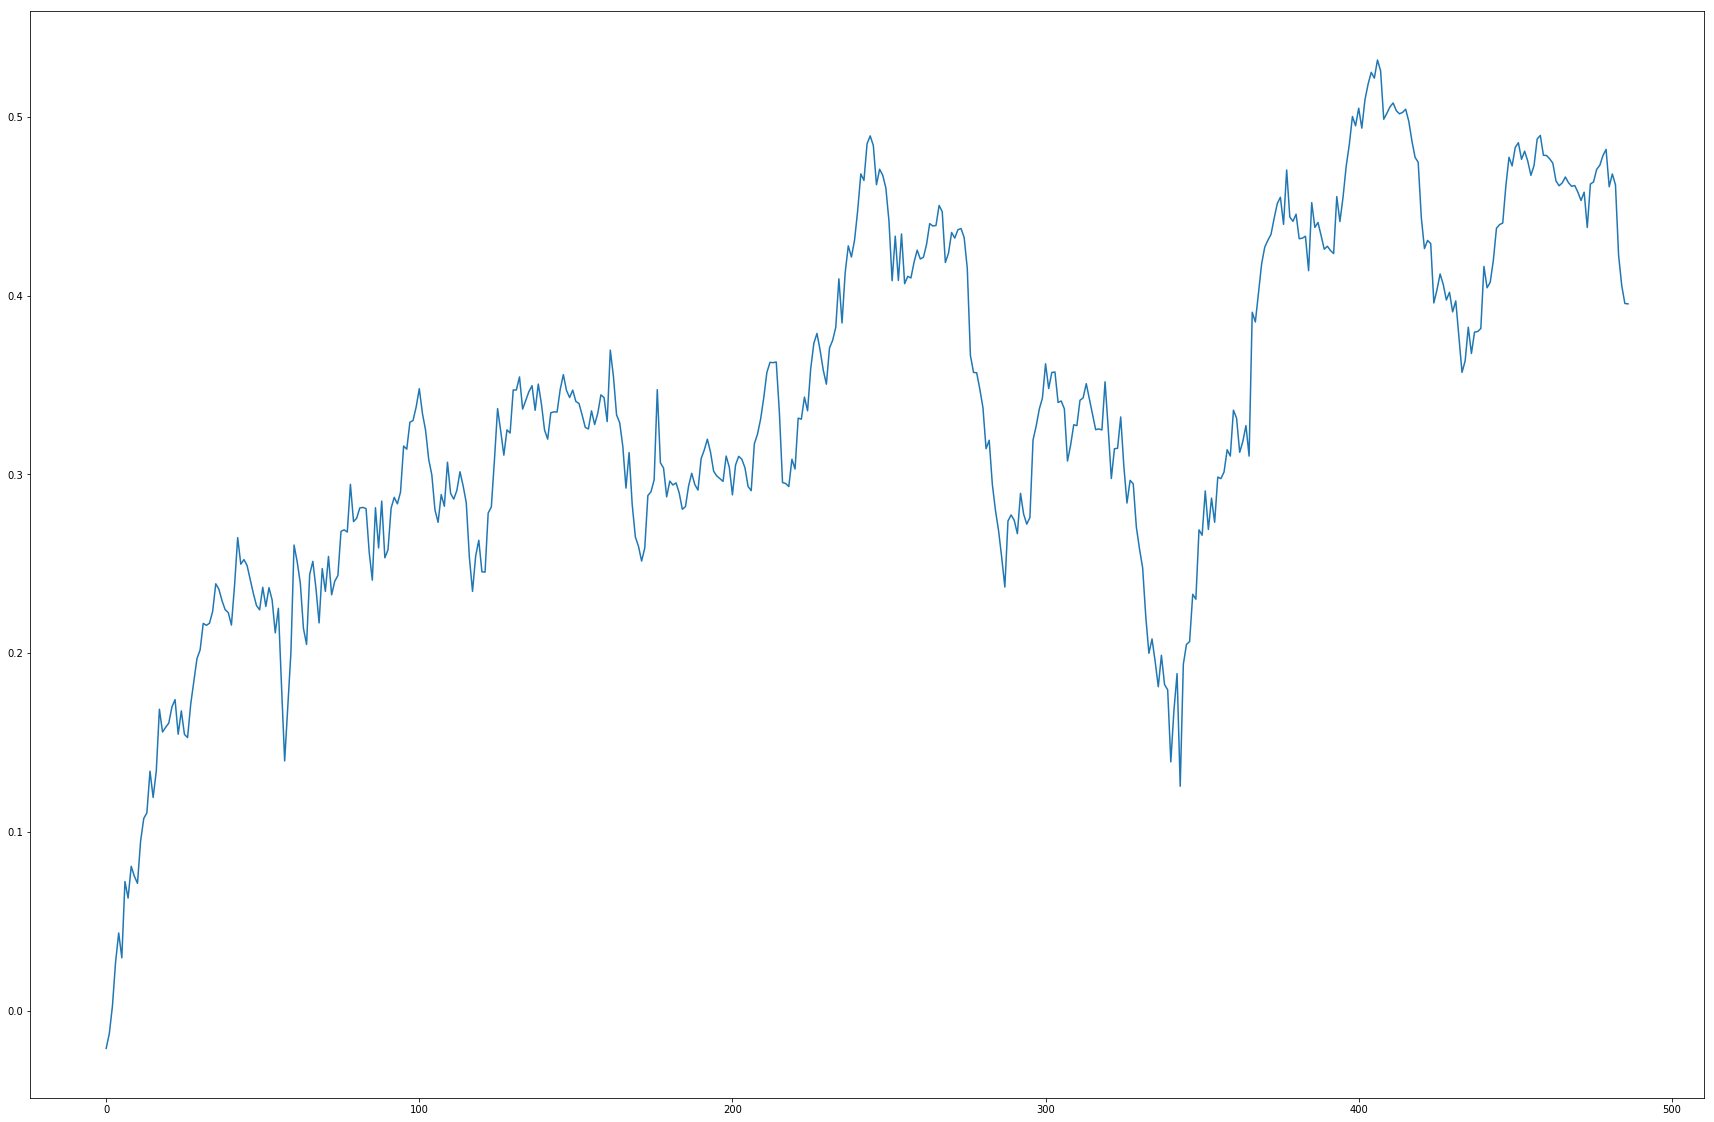

In [38]:
fig1,ax1=plt.subplots(figsize=(30,20))
ax1.plot(arr)